In [170]:
from glob import glob

In [171]:
m1 = glob('data/xrd_data/*1min*')
m2 = glob('data/xrd_data/*2min*')
m4 = glob('data/xrd_data/*4min*')

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


In [173]:
def load_one(path):
    return pd.read_csv(path).set_index('2theta')

In [174]:
df_m1 = pd.concat([load_one(p) for p in m1], axis = 1)
df_m2 = pd.concat([load_one(p) for p in m2], axis = 1)
df_m4 = pd.concat([load_one(p) for p in m4], axis = 1)

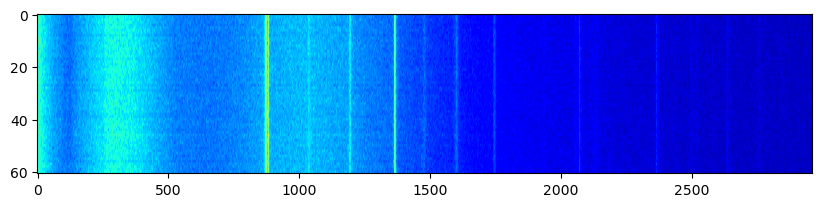

In [175]:
plt.imshow(df_m2.values.T, aspect = 10, cmap = 'jet')

In [29]:
patterns = df_m4.values.T

In [30]:
from xrdc import source_separation as sep

In [31]:
threshold = 20
bg_smooth = 20
bg_smooth_post = 20


background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = False,
                                 threshold = threshold, smooth_q = 1.7, smooth_neighbor_background = 0,
                                smooth_q_background = bg_smooth,
                                 bg_fill_method = 'simple')

(0, 0)


In [32]:
agged_background = np.mean(background, axis = 0)

background_variation = background - np.mean(background, axis = 0)

In [33]:
%matplotlib inline
sep.iplot_rows(patterns, background)

interactive(children=(IntSlider(value=29, description='i', max=59), Output(layout=Layout(height='550px'))), _d…

In [34]:
from xrdc.source_separation import gf

from sklearn.utils import resample

from scipy.stats import kstest

In [35]:
import slide_tricks as st

In [36]:
from xrdc import fourier
from xrdc import featurization as feat

In [37]:
%matplotlib inline

In [38]:
from scipy.signal import peak_widths as pw, find_peaks

In [39]:
sig = 2.5
# area= np.sqrt(2 * np.pi * sig**2)

In [40]:
integration_scale = 2 * np.pi * 2.35 * sig / 2

In [41]:
peak = fourier.lowpass_g(100, patterns[0])
#peak = peak / peak.sum()

# def mk_blocks_agg(arr):
#     return st.sliding_window_view(arr, (len(arr), 7)).squeeze()[::7].mean(axis = 2)


# def agg_2d(patterns):
#     agged_2d = st.sliding_window_view(patterns, (len(patterns), 7)).squeeze().mean(axis = 2).T
#     agged_2d = np.pad(agged_2d, ((0,), (3,)), mode = 'edge')
#     return agged_2d


# def conv2d(a, b):
#     return a
#     return np.vstack([np.convolve(p, b, 'same') for p in a])


# import matplotlib as mpl
# mpl.rcParams['figure.figsize'] =(8, 18)

# #agged_det = agg_2d((fast_q - background_variation)[:30])


In [89]:
peak.shape

(2962,)

In [42]:
subsample = 1

In [43]:
sig = np.sqrt((peak.sum()**2) / (2 * np.pi))
sig_int = int(sig)

In [44]:
blocksize = 10

In [45]:
def mk_pairs_mask(arr):
    """
    Select which q points count as background, then return a corresponding square boolean matrix
    """
    rowmask = (arr < np.percentile(arr, 50))
    #rowmask[:1300] = False

    pairs_mask = np.einsum('i,j->ij', rowmask, rowmask)
    return pairs_mask

In [46]:
from sklearn.utils import resample

In [47]:
def resample_2d(arr):
    N = len(arr)
    idx = np.arange(N).astype(int)
    return arr[resample(idx), :]

In [48]:
# def boot_stderr(arr2d):
#     return np.vstack([resample_2d(arr2d).mean(axis = 0) for _ in range(100)]).std(axis = 0)

In [82]:
import slide_tricks as st

def mk_blocks(arr):
    a3d = st.sliding_window_view(arr, (len(arr), blocksize)).squeeze()[::blocksize]
    return np.einsum('ijk->jik', (a3d))

def agg_2d(patterns):
    agged_2d = st.sliding_window_view(patterns, (len(patterns), blocksize)).squeeze().mean(axis = 2).T
    agged_2d = np.pad(agged_2d, ((0,), (3,)), mode = 'edge')
    return agged_2d

def boot_stderr(arr2d):
    return np.vstack([resample_2d(arr2d).mean(axis = 0) for _ in range(100)]).std(axis = 0)

def boot_mean(arr2d):
    return np.vstack([resample_2d(arr2d).mean(axis = 0) for _ in range(100)]).mean(axis = 0)

In [50]:
blocks = mk_blocks(fast_q)

In [51]:
blocks.shape

(60, 296, 10)

In [52]:
ii, jj, kk = np.arange(blocks.shape[0]), np.arange(blocks.shape[1]), np.arange(blocks.shape[2])

In [53]:
jjr = resample(jj)

In [54]:
(blocks[np.ix_(ii, jjr, kk)] == blocks[:, jjr, :]).all()

True

In [55]:
def sample_once(fast_q):
    blocks = mk_blocks(fast_q)
    return blocks[np.ix_(resample(ii), jj, resample(kk))]

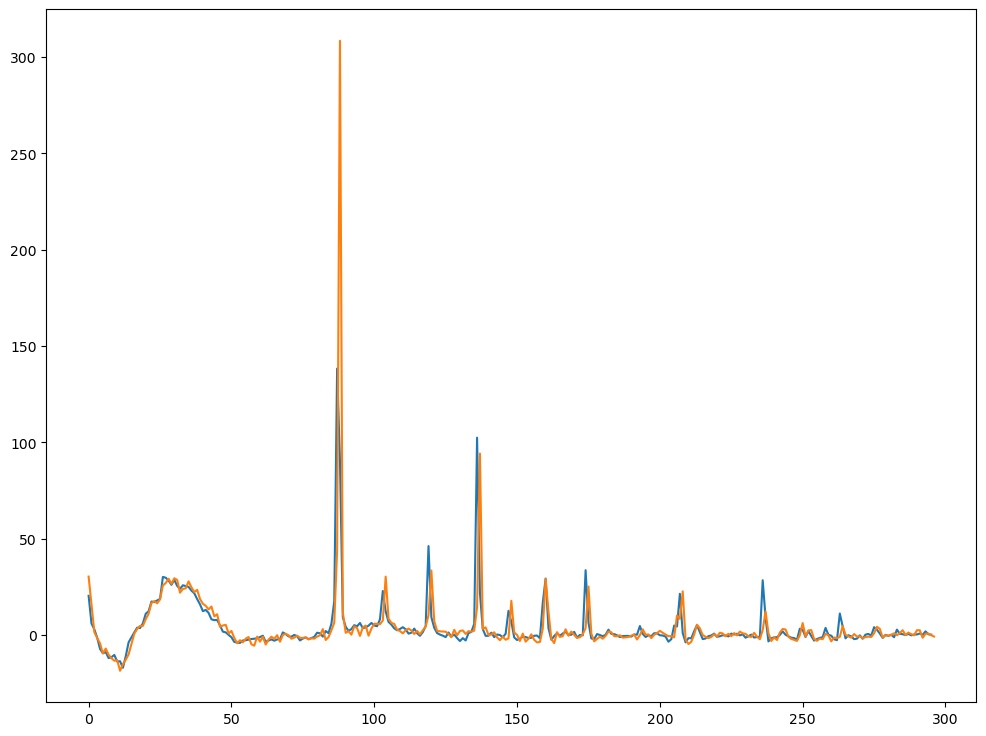

In [56]:
tmp = blocks[np.ix_(resample(ii), jj, resample(kk))]

plt.plot(tmp.mean(axis = 2).mean(axis = 0))
plt.plot(fast_q.mean(axis = 0)[::blocksize])

In [57]:
np.einsum('ijk->jik', mk_blocks(fast_q));

In [58]:
def c2d(arr, kernel):
    arr_conv = np.vstack([np.convolve(p, kernel, 'same') for p in arr])
    idxs = np.arange(len(arr[0]))
    return idxs, arr_conv

def get_aggregate_mean(arr, kernel, blocksize):
    idxs, arr_conv = c2d(arr, kernel)
    return idxs[::blocksize], np.mean(arr_conv[:, ::blocksize], axis = 0)

def get_aggregate_std(arr, kernel, blocksize):
    arr_conv = np.vstack([np.convolve(p, kernel, 'same') for p in arr])
    idxs = np.arange(len(arr))
    return idxs[::blocksize], np.std(arr_conv[:, ::blocksize], axis = 0)

def get_aggregate_stderr(arr, kernel, blocksize):
    idxs, arr_conv = c2d(arr, kernel)
    return idxs[::blocksize], arr_conv[:, ::blocksize],\
        arr_conv[:, ::blocksize].mean(axis = 0), boot_stderr(arr_conv[:, ::blocksize])

def cartesian_quad(a, b):
    b = b.reshape((b.shape[0], 1))
    return np.sqrt(a**2 + b**2)

def cartesian_diff(a, b):
    b = b.reshape((b.shape[0], 1))
    return b - a

In [59]:
def get_agged_zscores(fast_q, peak, blocksize, mask):
    _, agged, mean, sterr = get_aggregate_stderr(fast_q, peak, blocksize)
    pairwise_diffs = cartesian_diff(mean, mean) * mask
    pairwise_stderr = cartesian_quad(sterr, sterr) * mask
    zscores = (np.sum(np.abs(pairwise_diffs), axis = 0) / (pairwise_stderr + 1e-9).sum(axis = 0))
    return zscores

In [60]:
plt.plot(get_agged_zscores(fast_q, peak, blocksize, off_diag_mask))

NameError: name 'off_diag_mask' is not defined

In [61]:
_, agged, mean, sterr = get_aggregate_stderr(fast_q, peak, 10)
pairwise_diffs = cartesian_diff(mean, mean)
pairwise_stderr = cartesian_quad(sterr, sterr)
zscores = (np.abs(pairwise_diffs) / (pairwise_stderr + 1e-9))

arr = np.median(zscores, axis = 0)
rowmask = (arr < np.percentile(arr, 50))
select_zscores = np.einsum('i,j->ij', rowmask, ~rowmask)
bgmask_1d = (select_zscores == False).all(axis = 0)
off_diag_mask = (np.roll(np.eye(len(fast_q[0][::blocksize])), -1, axis = 0) +\
            np.roll(np.eye(len(fast_q[0][::blocksize])), 1, axis = 0)).astype(bool)

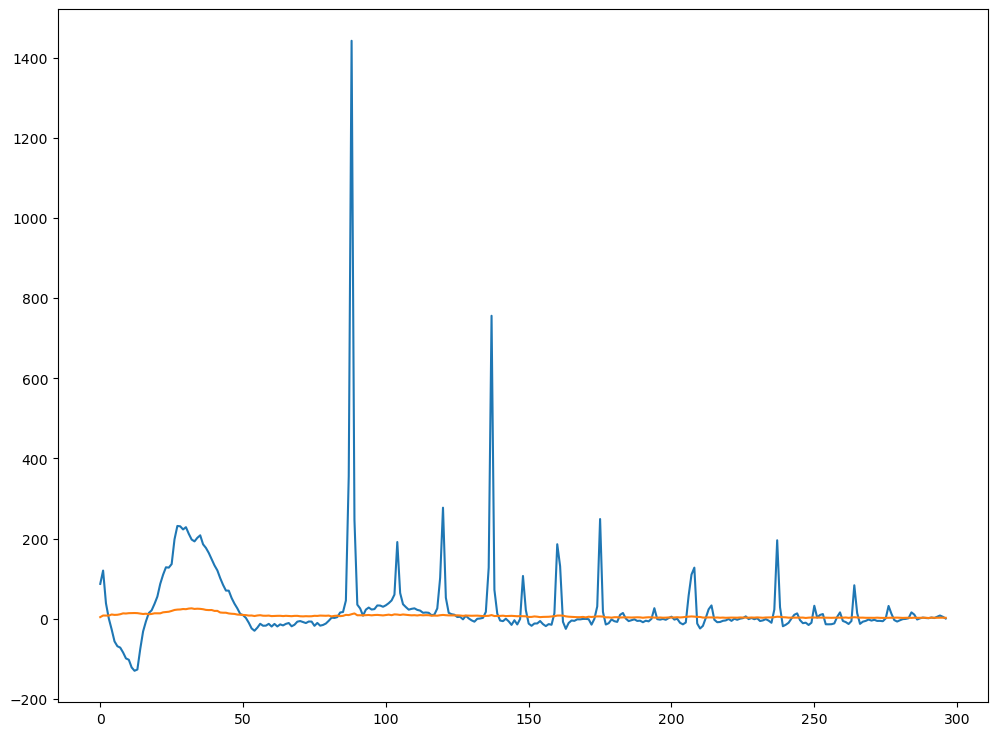

In [64]:
plt.plot(mean)
plt.plot(sterr)

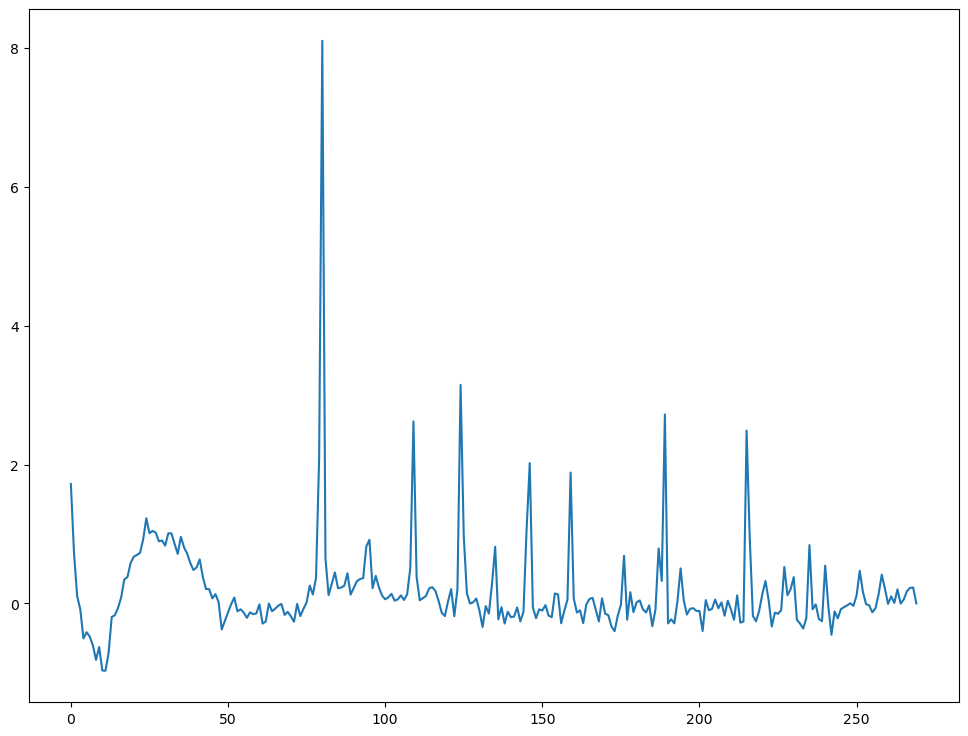

In [66]:
tmp = np.vstack([resample_2d(fast_q) for _ in range(100)])
plt.plot((tmp.mean(axis = 0) / tmp.std(axis = 0))[::11])

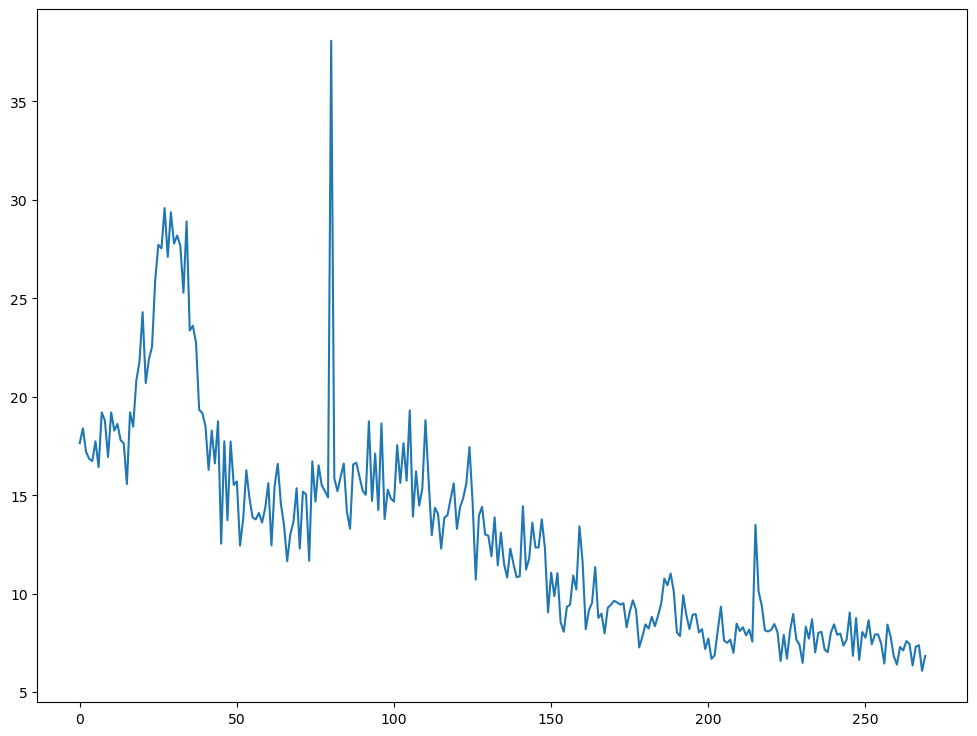

In [68]:
plt.plot(tmp.std(axis = 0)[::11])

In [46]:
tmp.shape

(546, 2962)

In [49]:
# _, agged, mean, sterr = get_aggregate_stderr(patterns, peak, 10)
# zscores = (np.abs(cartesian_diff(mean, mean)) / (cartesian_quad(sterr, sterr) + 1e-9))

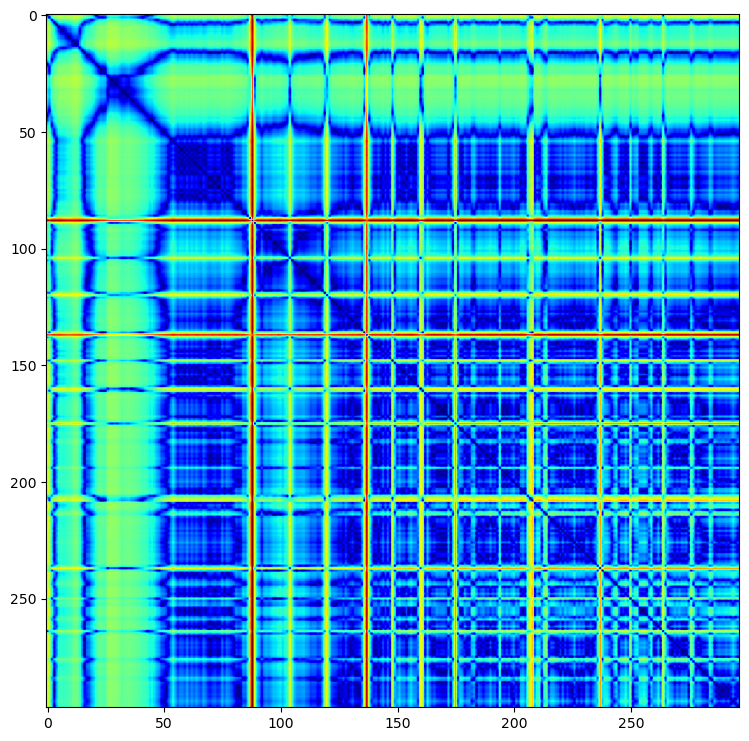

In [50]:
plt.imshow(np.log(1 + zscores), cmap = 'jet')
# plt.colorbar()

### pairwise z scores on raw data (no background subtraction)

<IPython.core.display.Javascript object>


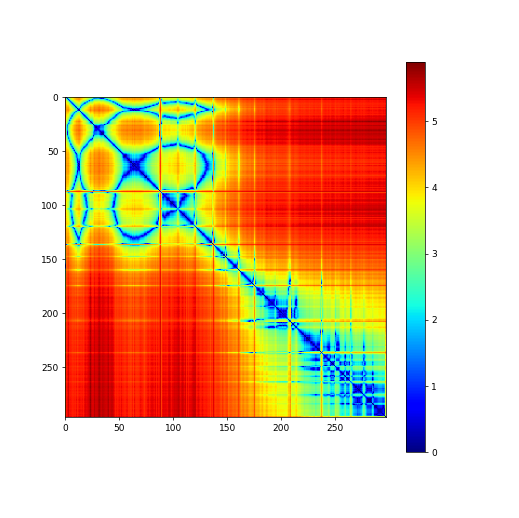

In [231]:
plt.imshow(np.log(1 + zscores), cmap = 'jet')
plt.colorbar()

In [51]:
from scipy.stats import pearsonr

In [54]:
mpl.rcParams['figure.figsize'] =(16, 8)

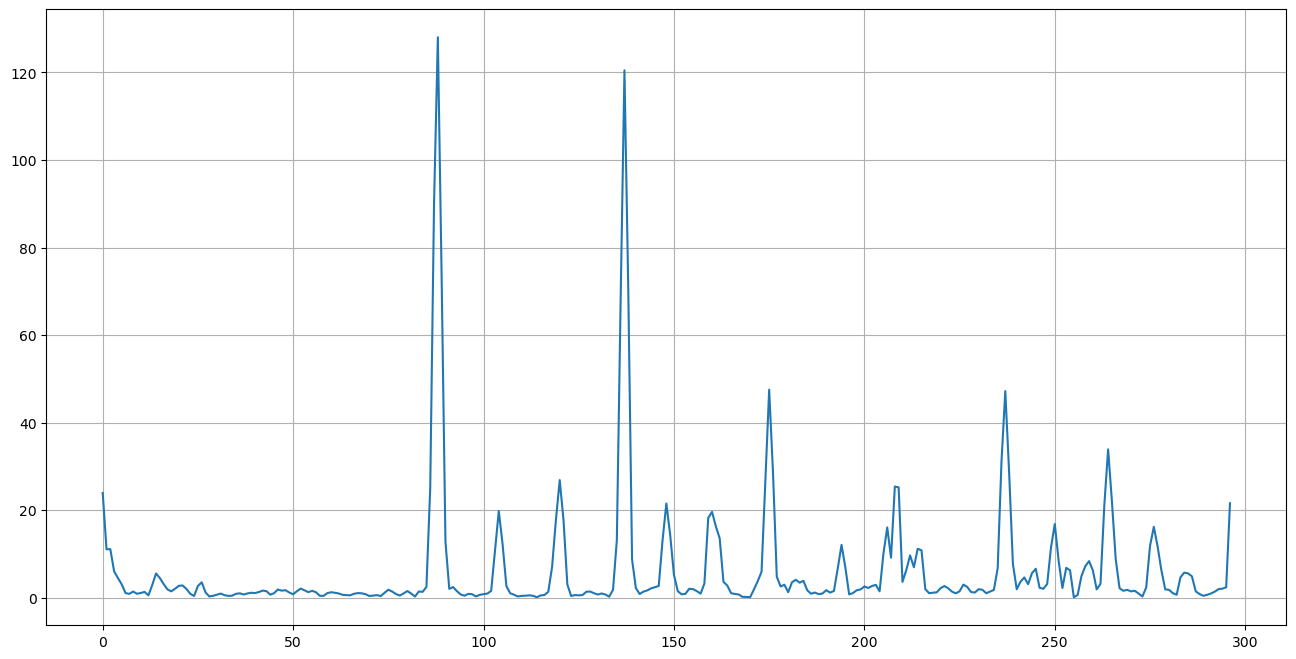

In [55]:
plt.plot((zscores * off_diag_mask).sum(axis = 0))
plt.grid()

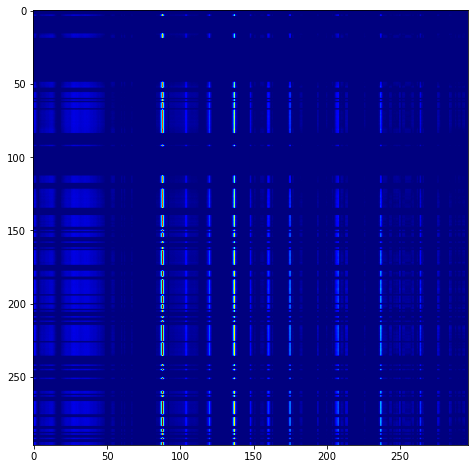

In [43]:
plt.imshow(select_zscores * zscores, cmap = 'jet')

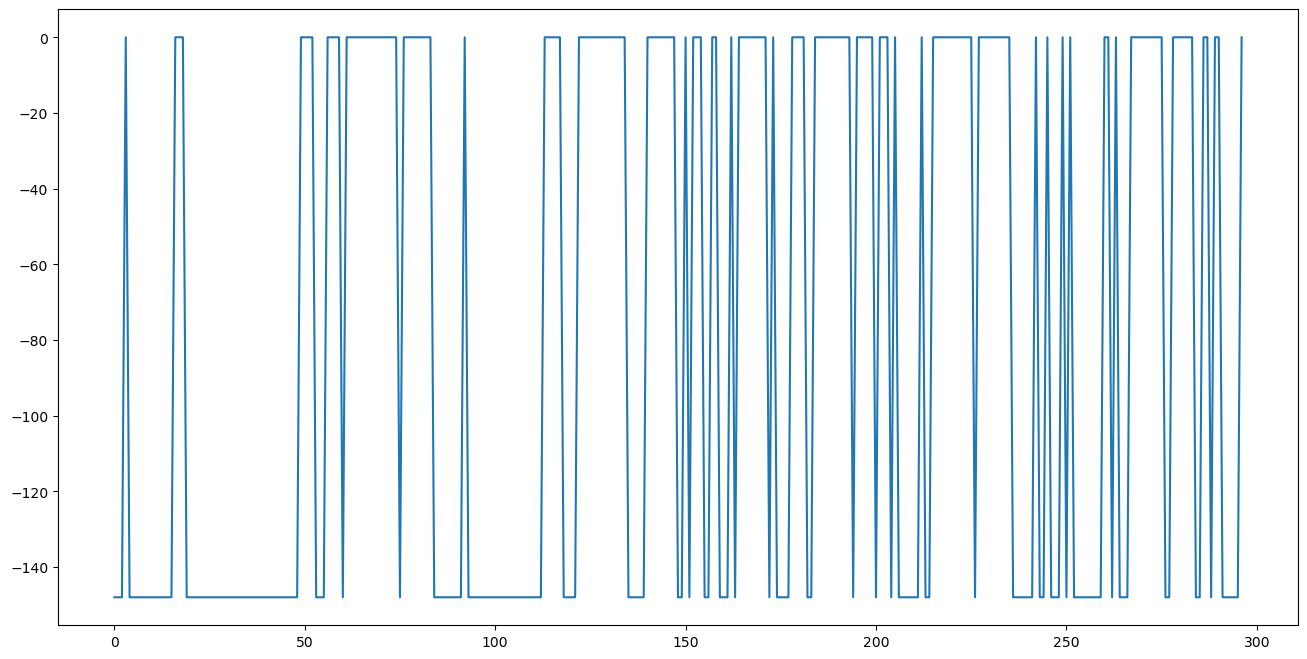

In [56]:
agged_mean_1d = np.sum(-1 * select_zscores, axis = 0)
plt.plot(agged_mean_1d)

In [57]:
agged_stderr_1d = np.sqrt(((select_zscores * pairwise_stderr)**2).sum(axis = 0))

In [58]:
pairs_mask = mk_pairs_mask(np.median(zscores_f, axis = 0))

NameError: name 'zscores_f' is not defined

In [ ]:
np.einsum('i,j->ij', rowmask, rowmask)

In [249]:
mean.shape

(297,)

There is some structure in the "no signal, no background" data, so Z scores will be underestimated because, whenever the background subtraction is poor, variance of the residual background will be misattributed to the signal regions.

<IPython.core.display.Javascript object>


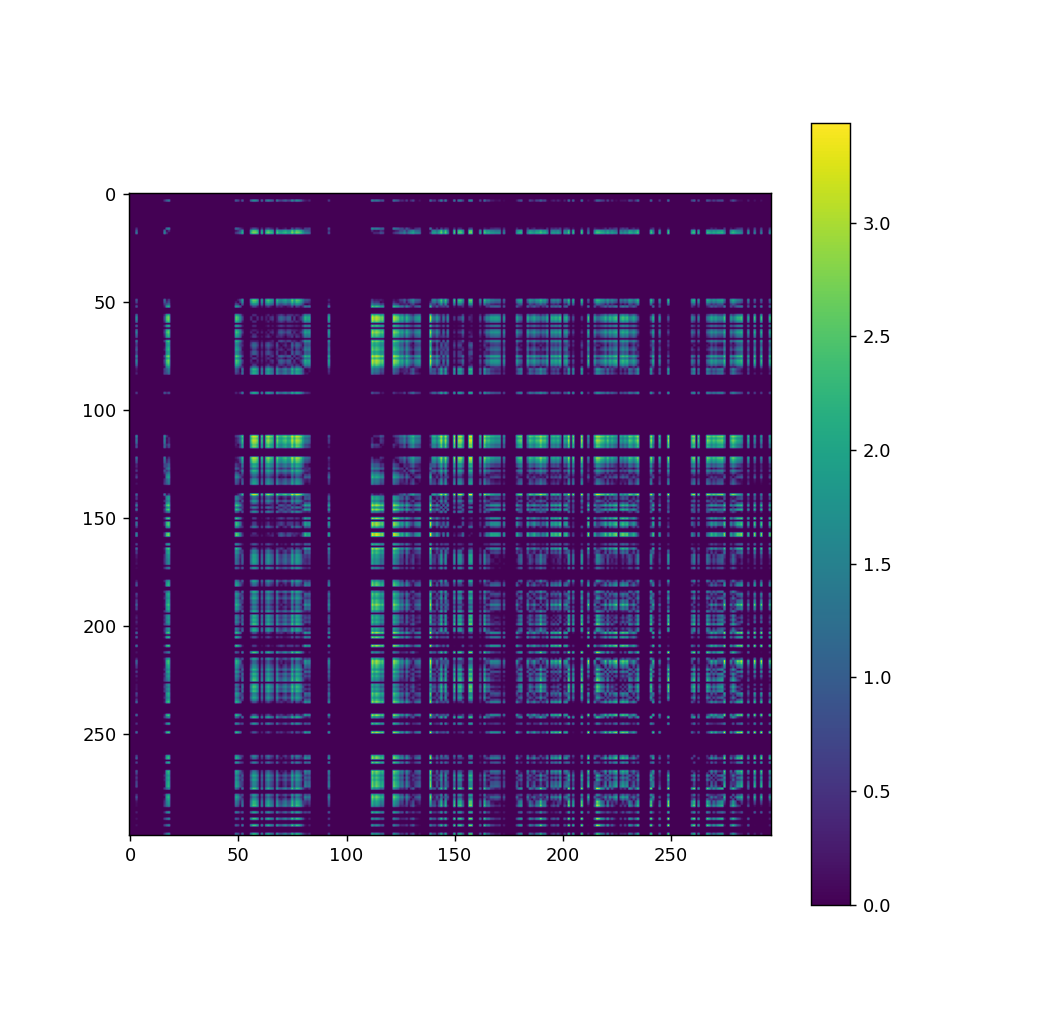

In [247]:
plt.imshow(pairs_mask * zscores)
plt.colorbar()

<IPython.core.display.Javascript object>


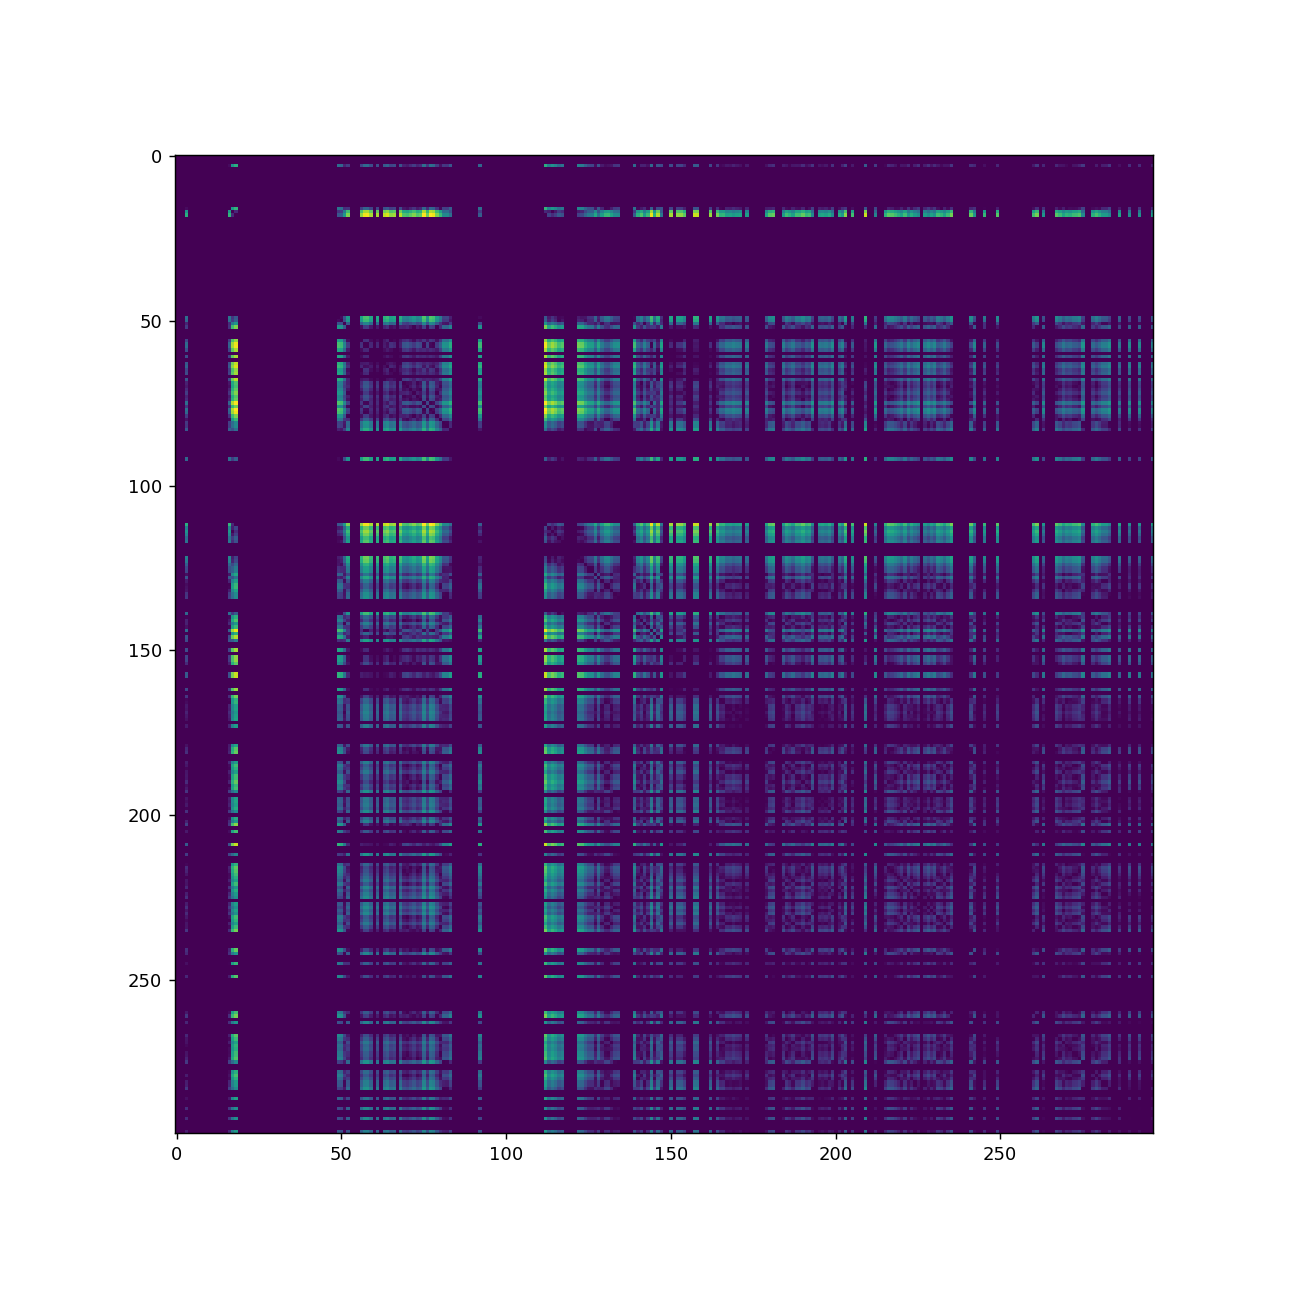

In [262]:
plt.imshow(np.abs(pairwise_diffs[::blocksize, ::blocksize]) * pairs_mask)
# plt.colorbar()

<IPython.core.display.Javascript object>


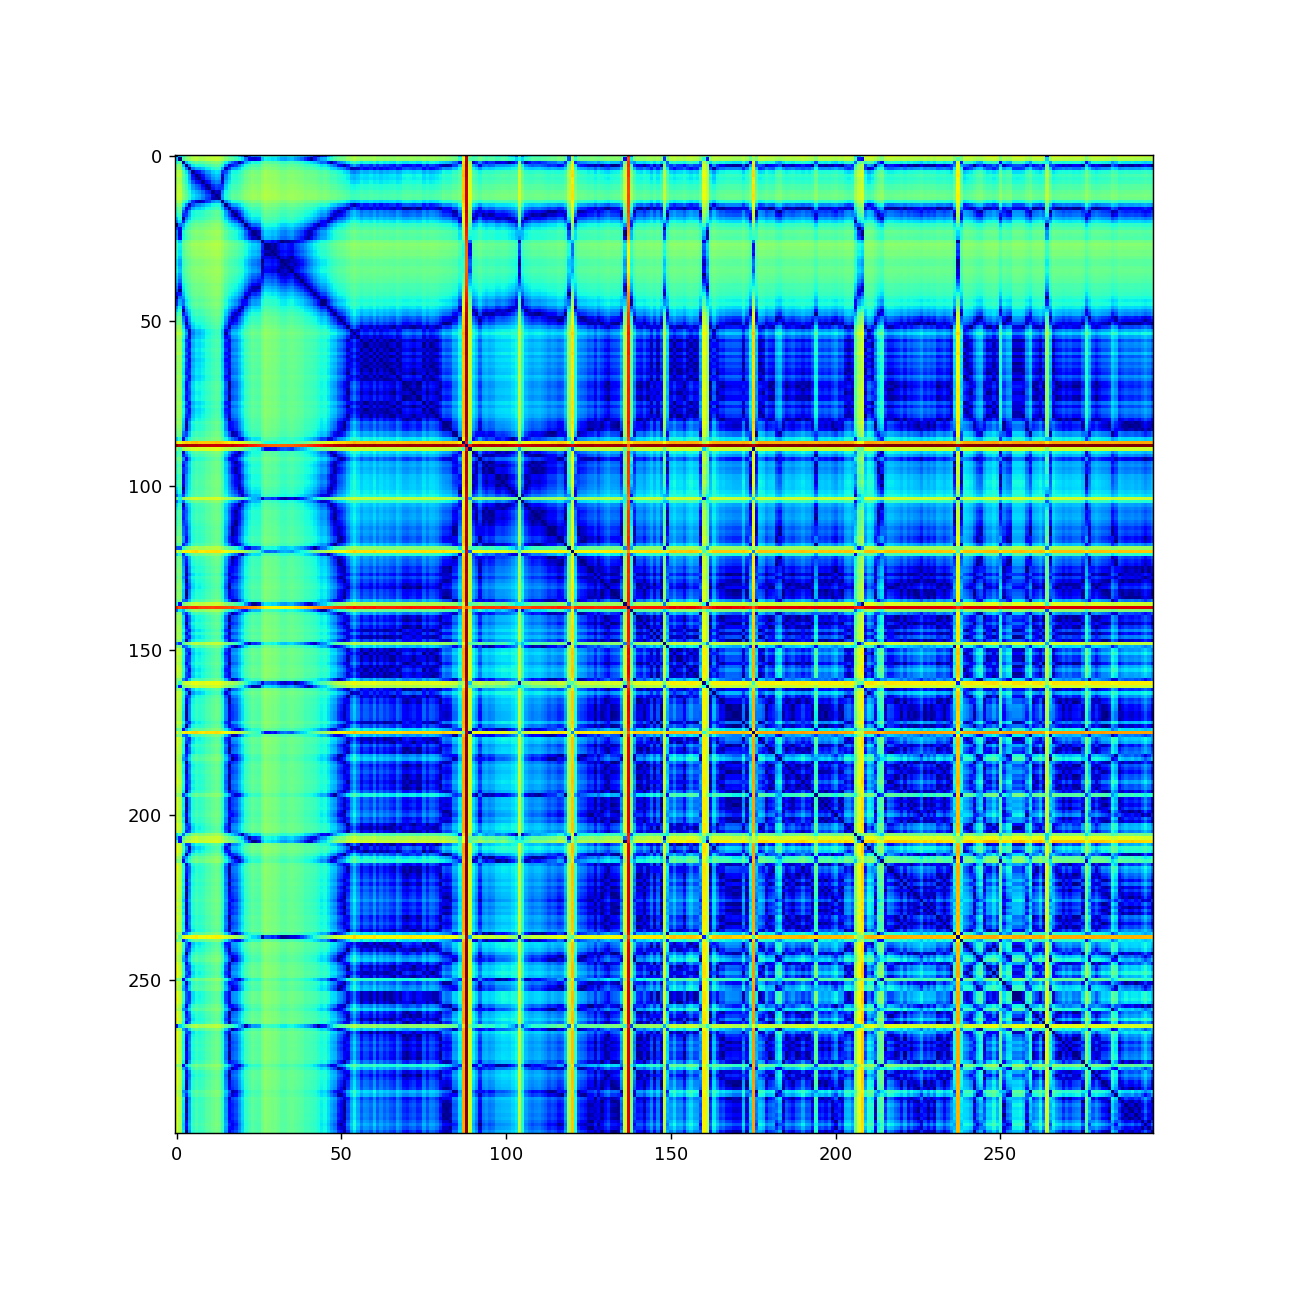

In [259]:
plt.imshow(np.log(1 + zscores), cmap = 'jet')

In [146]:
def cmp_zscores(fast_q, scores):
    a, b = 2, 1
    mpl.rcParams['figure.figsize'] =(10, 10)
    plt.subplot(a, b, 1)
    plt.grid()
    plt.plot(np.log(np.abs(100 * fast_q.mean(axis = 0) / 20))[::blocksize], label = 'N ={}'.format(fast_q.shape[0]))
    plt.grid()
    plt.ylim(0, None)
    plt.grid()

    plt.subplot(a, b, 2)

    plt.plot(np.log(1 + scores) , label = 'N ={}'.format(fast_q.shape[0]))

    plt.ylim(0., None)
    plt.ylabel('log(1 + Z score)')
    plt.grid()

    plt.hlines(np.log(4), 0, len(scores), color = 'k')
    
    
def plot_zscores_subsample_rows(fast_q, row_blocksize = 1, blocksize = 10, peak = peak, transpose = False):
    _, agged, mean, sterr = get_aggregate_stderr(fast_q[::row_blocksize], peak, blocksize)
    pairwise_diffs = cartesian_diff(mean, mean)
    pairwise_stderr = cartesian_quad(sterr, sterr)
    zscores = (np.abs(pairwise_diffs) / (pairwise_stderr + 1e-9))

    arr = np.median(zscores, axis = 0)
    rowmask = (arr < np.percentile(arr, 50))
    select_zscores = np.einsum('i,j->ij', rowmask, ~rowmask)
    bgmask_1d = (select_zscores == False).all(axis = 0)
    off_diag_mask = (np.roll(np.eye(len(fast_q[0][::blocksize])), -1, axis = 0) +\
                np.roll(np.eye(len(fast_q[0][::blocksize])), 1, axis = 0)).astype(bool)
    
    if not transpose:
        cmp_zscores(fast_q[::row_blocksize], get_agged_zscores(fast_q[::row_blocksize], peak, blocksize, off_diag_mask))
    else:
        off_diag_mask = (np.roll(np.eye(len(fast_q[0][::blocksize].T)), -1, axis = 0) +\
            np.roll(np.eye(len(fast_q[0][::blocksize].T)), 1, axis = 0)).astype(bool)
        cmp_zscores(fast_q[::row_blocksize].T, get_agged_zscores(fast_q[::row_blocksize].T, peak.T, 1, off_diag_mask))
        

mark

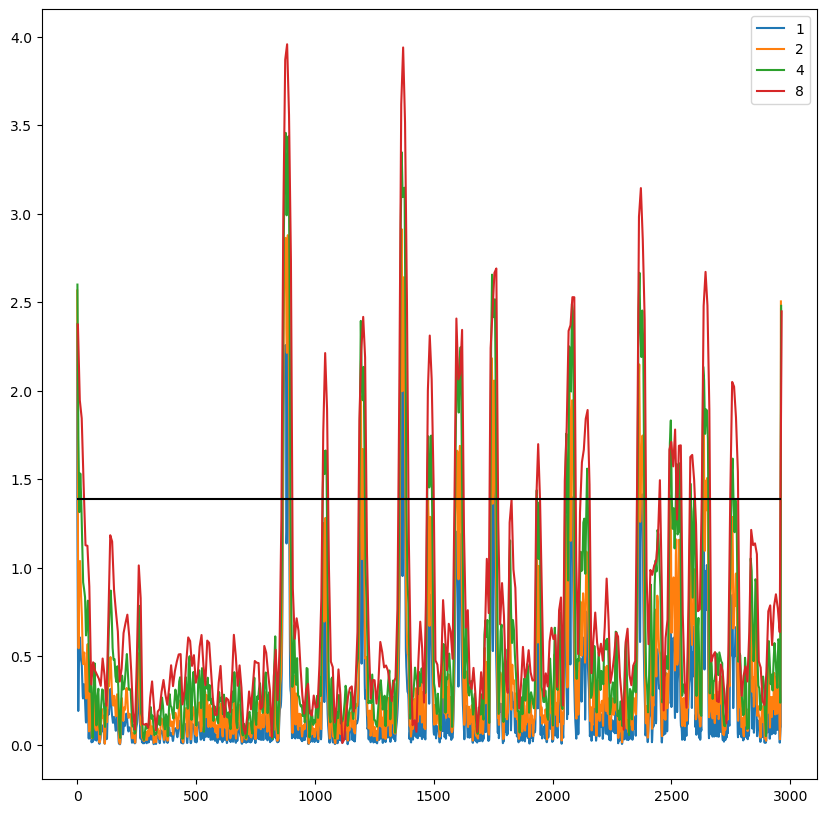

In [183]:
def plot_z_blocksize(fast_q, blocksize, plot = True):    
    padded = np.pad(fast_q[0], (0, blocksize - (len(fast_q[0]) % blocksize)), mode = 'edge')
    qblocks = padded.reshape((-1, blocksize)).T
    qpoints = np.arange(len(padded)).reshape((-1, blocksize)).T.mean(axis = 0)
    off_diag_mask = (np.roll(np.eye(len(fast_q[0][::blocksize])), -1, axis = 0) +\
                np.roll(np.eye(len(fast_q[0][::blocksize])), 1, axis = 0)).astype(bool)
    
    zloc = get_agged_zscores(fast_q, peak, blocksize, off_diag_mask)
    #plt.plot(qpoints[:len(zloc)], zloc, label = blocksize)
    if plot:
        plt.plot(qpoints[:len(zloc)], np.log(1 + zloc), label = blocksize)
    return zloc

plot_z_blocksize(fast_q, 1)
plot_z_blocksize(fast_q, 2)
plot_z_blocksize(fast_q, 4)
plot_z_blocksize(fast_q, 8)

plt.hlines(np.log(4), 0, len(fast_q[0]), color = 'k')

plt.legend()

In [291]:
blocksizes = np.unique(np.logspace(0, np.log10(len(fast_q[0])), 100).astype(int))[:-40]

In [310]:
blocksizes = np.arange(1, 51)

In [311]:
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant')

In [312]:
from scipy.interpolate import interp1d

In [313]:
def padded_zscores(bs):
    arr = plot_z_blocksize(fast_q, bs, plot = False)
    shape = 2962
    pad = bs - (len(arr) % bs)# - (shape % bs)#shape - len(arr)
    qpoints = np.arange(len(arr) * bs).reshape((-1, bs)).T.mean(axis = 0)
    fn = interp1d(qpoints, arr, fill_value = 'extrapolate')
    return fn(np.arange(shape))

In [330]:
def agged(bs):
    pad = max(0, bs - (len(fast_q[0]) % bs))
    arr = np.pad(fast_q.mean(axis = 0), (0, pad)).reshape((-1, bs)).mean(axis = 1)
    qpoints = np.arange(len(arr) * bs).reshape((-1, bs)).T.mean(axis = 0)
    fn = interp1d(qpoints, arr, fill_value = 'extrapolate')
    return fn(np.arange(shape))

In [314]:
z_vs_blocksize = np.vstack([
    padded_zscores(bs)
        for bs in blocksizes])

In [333]:
raw_vs_blocksize = np.vstack([
    agged(bs)
        for bs in blocksizes])

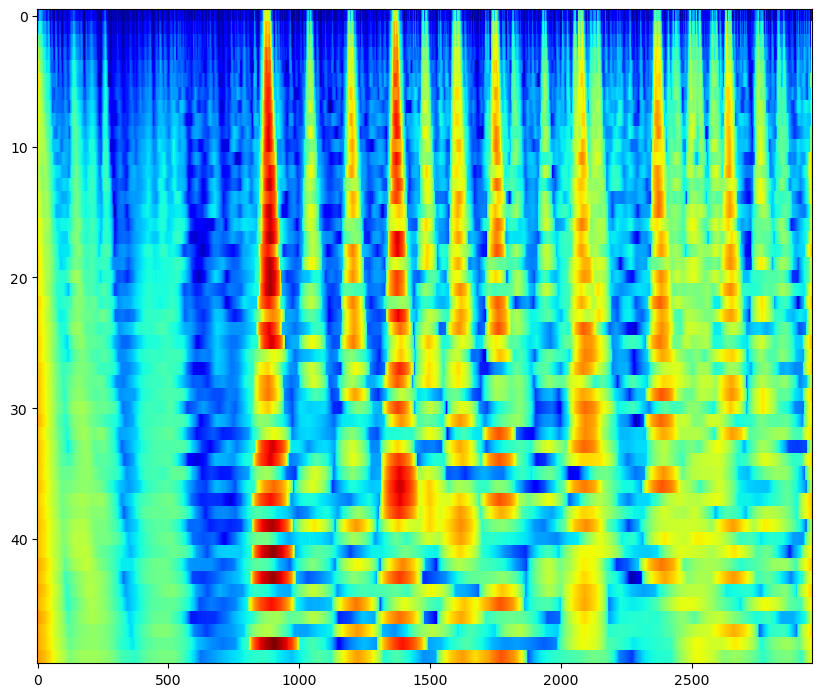

In [320]:
plt.imshow(np.log(.1 + z_vs_blocksize), aspect = 50, cmap = 'jet', interpolation='none')
#plt.colorbar()

In [337]:
raw_vs_blocksize.min()

-22.478838636338796

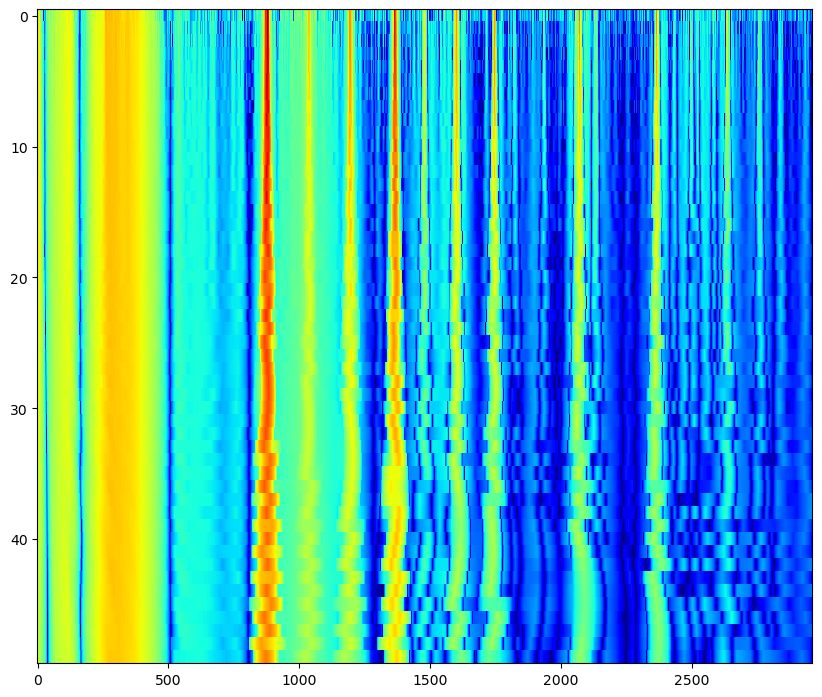

In [339]:
plt.imshow(np.log(.1 + np.abs(raw_vs_blocksize)), aspect = 50, cmap = 'jet', interpolation='none')

In [ ]:
plt.imshow()

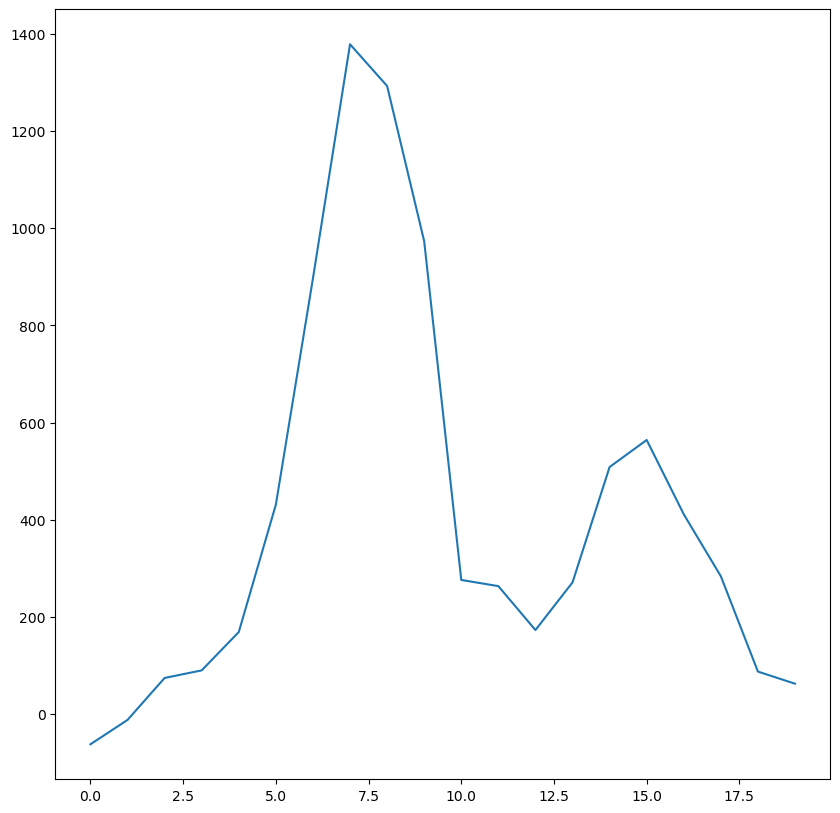

In [180]:
plt.plot(fast_q.sum(axis = 0)[2630:2650])

### Using 'local' z scores from the near-diagonal band:

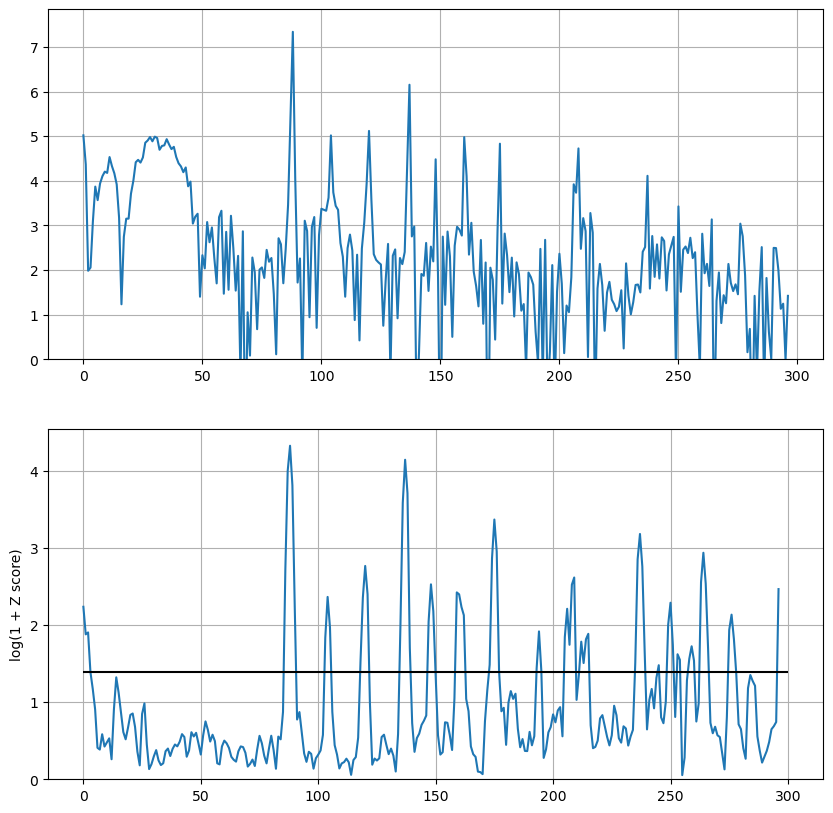

In [61]:
cmp_zscores(fast_q, get_agged_zscores(fast_q, peak, blocksize, off_diag_mask))

### Using globally-aggregated ones

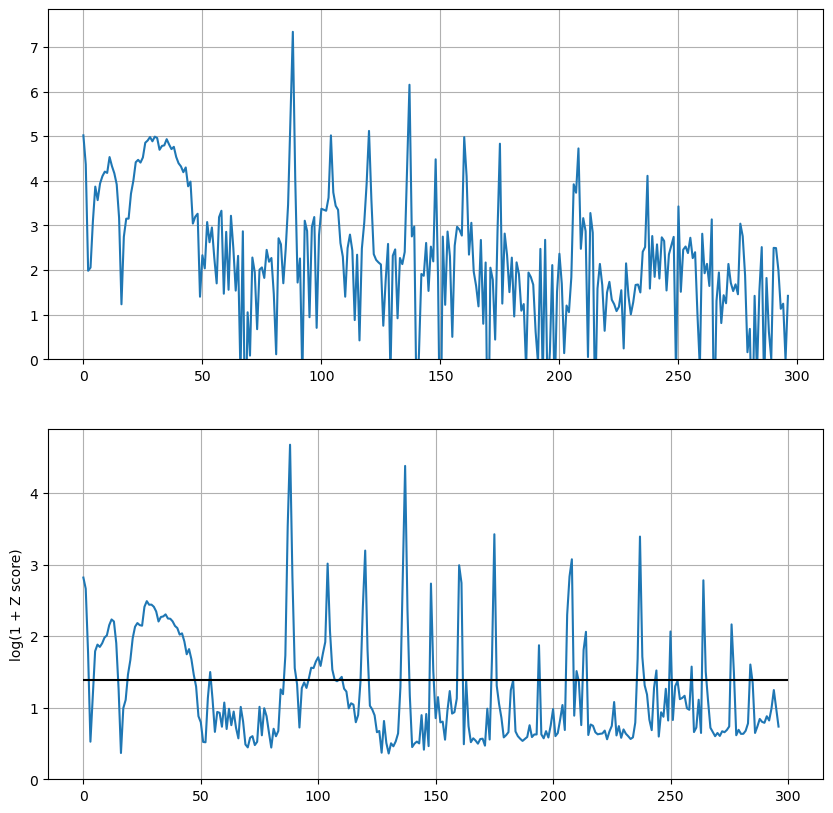

In [63]:
cmp_zscores(fast_q, np.median(zscores[bgmask_1d], axis = 0))

### Compare N = 60 to N = 6

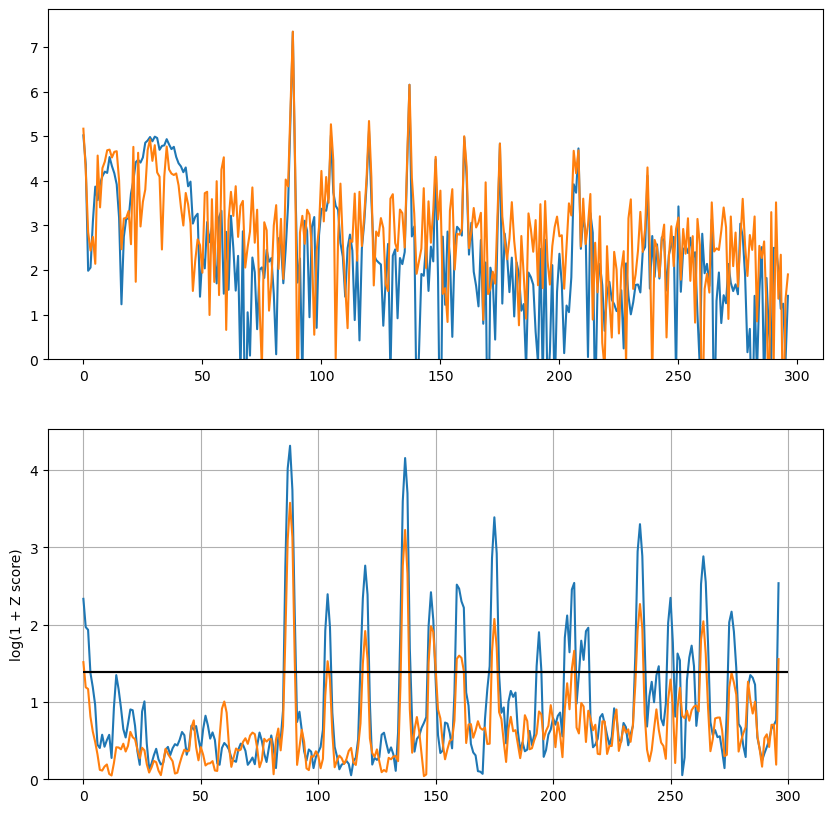

In [65]:
plot_zscores_subsample_rows(fast_q, 1, 10)
plot_zscores_subsample_rows(fast_q, 10, 10)
plt.grid()

In [41]:
blocksize = 1

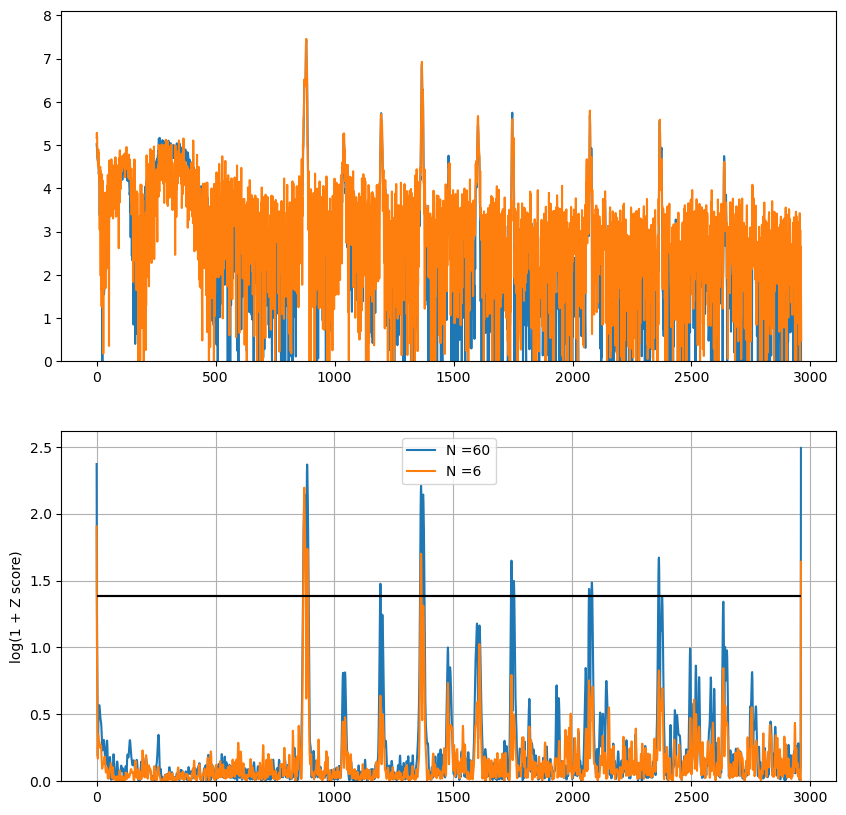

In [56]:
plot_zscores_subsample_rows(fast_q, 1, 1)
plt.legend()
plot_zscores_subsample_rows(fast_q, 10, 1)
plt.legend()
plt.grid()

mark

In [134]:
def plot_q_zscores(arr1d, blocksize):
    #blocksize = 3
    #arr1d = patterns[0]#np.convolve(patterns[0], peak, mode = 'same')
    padded = np.pad(arr1d, (0, blocksize - (len(arr1d) % blocksize)), mode = 'edge')
    qblocks = padded.reshape((-1, blocksize)).T
    qpoints = np.arange(len(padded)).reshape((-1, blocksize)).T.mean(axis = 0)

    qpeak = np.ones_like(qblocks[0])

    qmean = boot_mean(qblocks)

    qsterr = boot_stderr(qblocks)

    q_zscores = np.abs(cartesian_diff(qmean, qmean)) / (cartesian_quad(qsterr, qsterr) + 1e-9)

    off_diag_mask = (np.roll(np.eye(len(padded[::blocksize])), -1, axis = 0) +\
                np.roll(np.eye(len(padded[::blocksize])), 1, axis = 0)).astype(bool)

    plt.plot(qpoints, (q_zscores * off_diag_mask).sum(axis = 0), label = blocksize)

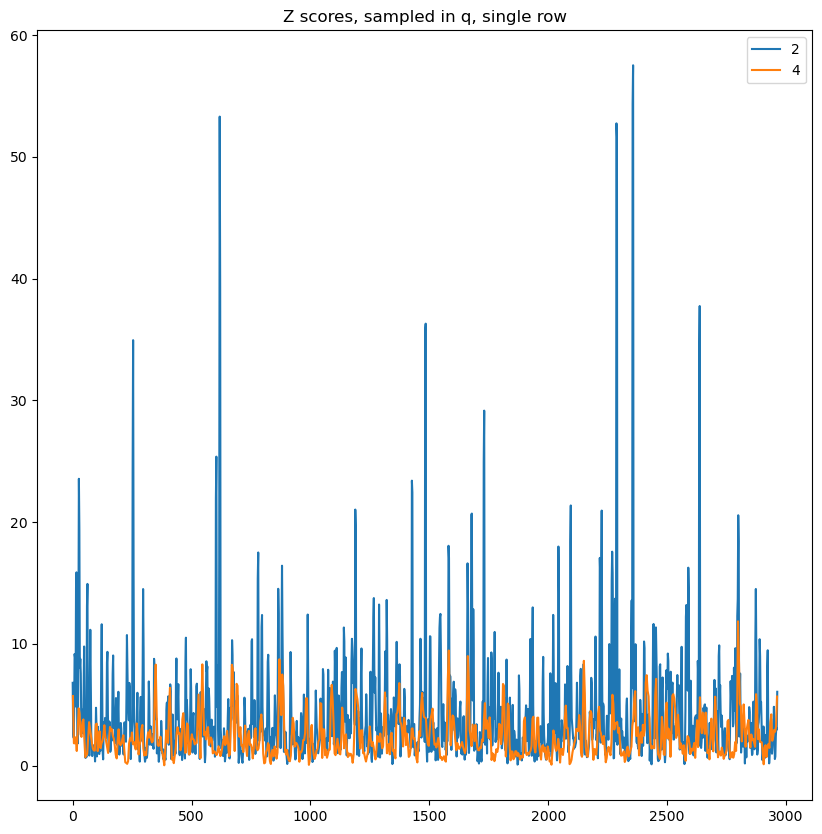

In [140]:
#plot_q_zscores(fast_q[10], 1)
plot_q_zscores(fast_q[8], 2)
plot_q_zscores(fast_q[8], 4)
plt.title('Z scores, sampled in q, single row')
plt.legend()

In [99]:
cartesian_diff(qbloc)

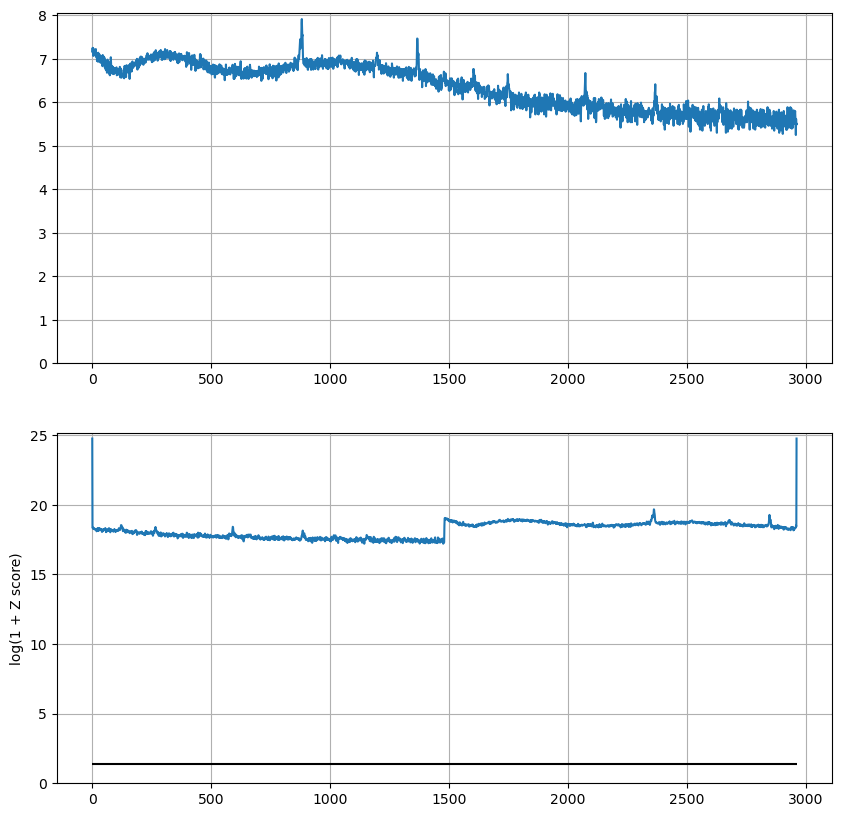

In [98]:
plot_zscores_subsample_rows(qblocks, row_blocksize = blocksize, blocksize = 1, peak = qpeak)


In [67]:
blocksize = 1

In [25]:
pairwise_diffs, pairwise_stds, ratio = compute_zscores(subsample)
rowmask = (np.median(fast_q, axis = 0) < np.percentile(np.median(fast_q, axis = 0), 50))
rowmask[:1300] = False

pairs_mask = np.einsum('i,j->ij', rowmask, rowmask)

imask = np.arange(len(ratio))[rowmask]

std_agg_ratio = pairwise_diffs[imask][::blocksize].sum(axis = 0) /\
    np.sqrt((pairwise_stds[imask][::blocksize]**2).sum(axis = 0))

(60, 2962)
(2962,) (60, 2962)


In [95]:
tmp = feat.l2_pairs(det.T)

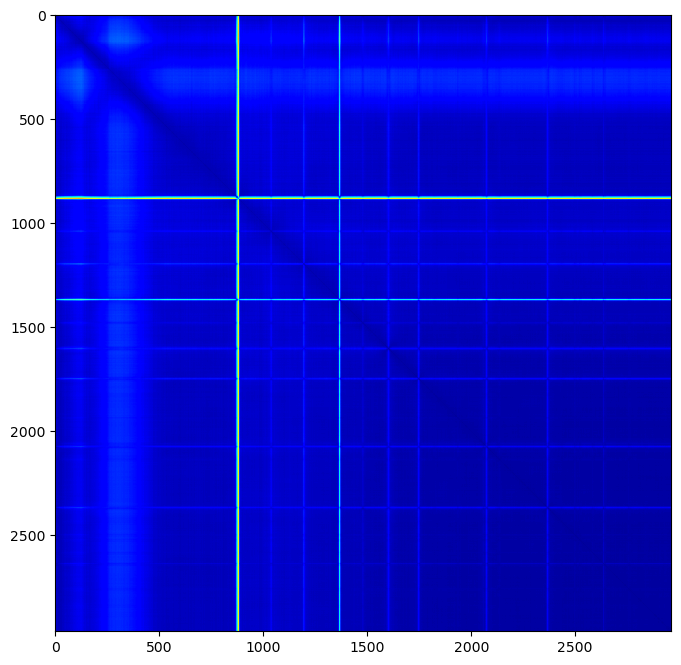

In [99]:
%matplotlib inline
plt.imshow(tmp, cmap = 'jet')

In [ ]:
# rowmask = (np.median(fast_q, axis = 0) < np.percentile(np.median(fast_q, axis = 0), 50))
# rowmask[:1300] = False

# imask = np.arange(len(ratio))[rowmask]

<IPython.core.display.Javascript object>


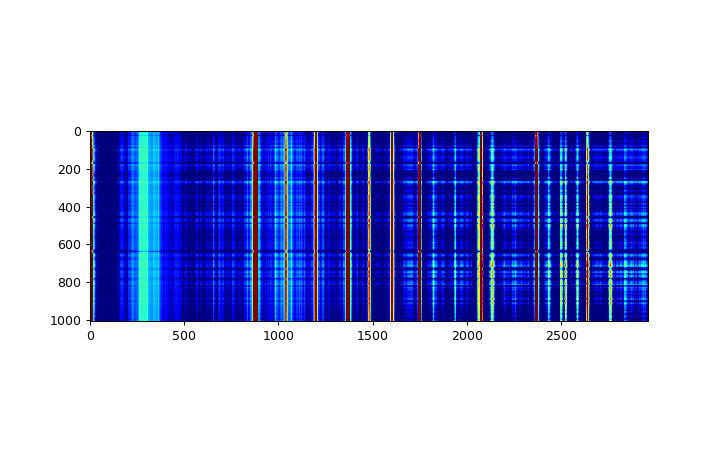

In [33]:
mpl.rcParams['figure.figsize'] =(8, 5)

plt.imshow(ratio[imask, :], cmap = 'jet', aspect = 1, vmin = 0, vmax = 2, interpolation = 'none')

<IPython.core.display.Javascript object>


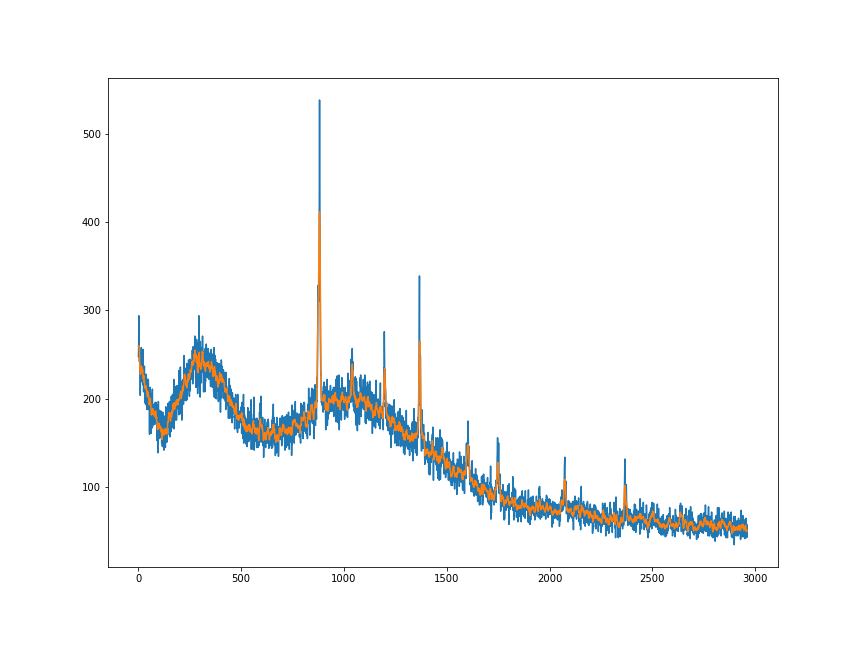

In [119]:
%matplotlib notebook
i = 10
plt.plot(patterns[i])
plt.plot(agged_2d[i])

In [49]:
def resample_2d(arr):
    N = len(arr)
    idx = np.arange(N).astype(int)
    return arr[resample(idx), :]
    

<IPython.core.display.Javascript object>


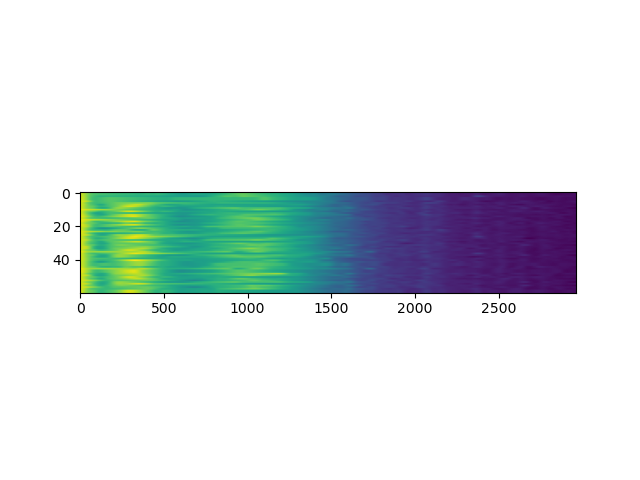

In [56]:
plt.imshow(resample_2d(background), aspect = 10)

In [46]:
N = len(patterns)
aggregate_uncertainty = np.sqrt((fast_T.std(axis = 0)**2 + background.std(axis = 0)**2) / N)
background = gf(background, (0, bg_smooth_post))
aggregate_uncertainty = gf(aggregate_uncertainty, bg_smooth_post)

Ideas

different z scores for features of different sizes?